In [1]:
import os
if not os.path.exists('steps'):
    os.mkdir('steps')

In [2]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import copy
import random
import time
import pickle
from torch.nn.utils._per_sample_grad import call_for_per_sample_grads
from scipy import ndimage
from matplotlib import pyplot as plt

torch.set_printoptions(precision=3)
cuda = True if torch.cuda.is_available() else False

In [3]:
def normalize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().cpu().numpy()
    trans = np.transpose(npimg, (1,2,0))
    return np.squeeze(trans)

def imshow(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.show()
    
def imsave(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.axis("off")
    plt.savefig("inversion.png", dpi=300)
    plt.show()

In [4]:
def invert(model, x, y, num_iters=5000, learning_rate=1, show=False, refine=True, t1 = -1/6, t2 = -1):
    model.eval()
    loss = 10000000

    for i in range(num_iters + 1):
        if i % 100 == 0:
            print("\rIteration: {}\tLoss: {}".format(i, loss), end="")
        x.requires_grad = True
        x.grad = None
        model.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        with torch.no_grad():
            x = x - learning_rate*x.grad
            if refine:
                if i % 500 == 0 and i > 0 and i < num_iters:
                    x = ndimage.median_filter(x.detach().cpu(), size=2)
                    blur = ndimage.gaussian_filter(x, sigma=2, truncate=t1)
                    filter_blur = ndimage.gaussian_filter(blur, sigma=1, truncate=t2)
                    x = blur + 80 * (blur - filter_blur)
                    x = torch.from_numpy(x).to(device)
  
    return x[0]

In [5]:
def generate(model, target, learning_rate=1, num_iters=8000, examples=1, show = False, div=256, shape=(1,1,28,28)):
    images = []
    for i in range(examples):

        print("\nInversion {}/{}".format(i+1, examples))
        noise = torch.rand(shape, dtype=torch.float, device=device)
        noise /= div
        noise -= 1
        noise.requires_grad=True
        targetval = torch.tensor([target], device=device, requires_grad=False)
        image = invert(model, noise, targetval, show=False, learning_rate=learning_rate, num_iters=num_iters,
                        refine=True)
        images.append(image.detach().cpu())
        if show:
            images = torch.stack(images)
            imshow(torchvision.utils.make_grid(images, nrow=4))
    return images

In [6]:
P=.25
mode = 'resnet'
dataset = 'mnist'

torch.manual_seed(42)

In [7]:
class IndexingDataset(Dataset):
    def __init__(self, internal_dataset):
        self.dataset = internal_dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, sample_index):
        r = self.dataset[sample_index]
        if not isinstance(r, tuple):
            r = (r,)
        return *r, sample_index
    
# Transform image to tensor and normalize features from [0,255] to [0,1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,)),
                                ])
if dataset == 'cifar':
    to_forget = 81
    num_classes = 100
    max_count = -1
    in_size = 3
    # Using MNIST
    data = datasets.CIFAR100('/data', download=True, train=True, transform=transform)
    traindata = IndexingDataset(data)
    testdata = datasets.CIFAR100('/data', download=True, train=False, transform=transform)
else:
    to_forget = 3
    num_classes = 10
    max_count = 100
    in_size = 1
    # Using MNIST
    data = datasets.MNIST('/data', download=True, train=True, transform=transform)
    traindata = IndexingDataset(data)
    testdata = datasets.MNIST('/data', download=True, train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17716247.98it/s]


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468653.55it/s]


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4425507.73it/s]


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2967834.36it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [8]:
# Loaders that give 64 example batches
all_data_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
all_data_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)

target_index = []
nontarget_index = []
for i in range(0, len(testdata)):
    if testdata[i][1] == to_forget:
        target_index.append(i)
    else:
        nontarget_index.append(i)
target_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(target_index))
nontarget_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(nontarget_index))

target_index = []
nontarget_index = []
count = 0
for i in range(0, len(traindata)):
    if traindata[i][1] != to_forget:
        target_index.append(i)
        nontarget_index.append(i)
    if traindata[i][1] == to_forget and (count < max_count or max_count < 1):
        count += 1
        target_index.append(i)
target_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(target_index))
nontarget_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(nontarget_index))


unlearningdata = copy.deepcopy(data)
unlearninglabels = list(range(num_classes))
unlearninglabels.remove(to_forget)
for i in range(len(unlearningdata)):
    if unlearningdata.targets[i] == to_forget:
        unlearningdata.targets[i] = random.choice(unlearninglabels)
unlearning_train_loader = torch.utils.data.DataLoader(IndexingDataset(unlearningdata), batch_size=64, shuffle=True)

In [9]:
class SimpleModel(nn.Module):
    def __init__(self, in_size, out_size, h_size=100):
        super().__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        self.h_size = h_size
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_size, h_size, 3, 2, padding=1),
            nn.LeakyReLU(.1),
            nn.Conv2d(h_size, h_size, 3, 2, padding=1),
            nn.LeakyReLU(.1),
            nn.AdaptiveMaxPool2d((2,2)),
            nn.Flatten(1),
            nn.Linear(4 * h_size, out_size)
        )
        
        nn.init.xavier_normal_(self.layers[0].weight)
        nn.init.zeros_(self.layers[0].bias)
        nn.init.xavier_normal_(self.layers[2].weight)
        nn.init.zeros_(self.layers[2].bias)
        nn.init.xavier_normal_(self.layers[6].weight)
        nn.init.zeros_(self.layers[6].bias)
        
    def forward(self, x):
        return self.layers(x)

In [10]:
# Hyperparameters
batch_size_train = 64
batch_size_test = 64
log_interval = 16
torch.backends.cudnn.enabled = True
criterion = F.cross_entropy

In [11]:
# Training method
def train(model, epoch, loader, returnable=False, keep_p=.1):
    model.train()
    if returnable:
        batches = []
    for batch_idx, (data, target, samples_idx) in enumerate(loader):
        for param in model.parameters():
            param.grad_sample = None
        data = data.to(device)
        output = call_for_per_sample_grads(model)(data)
        loss = criterion(output, target.to(device))
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param.grad = param.grad_sample.sum(0)
                
        optimizer.step()
        
        with torch.no_grad():
            for i, sample_idx in enumerate(samples_idx[target == to_forget].tolist()):
                rng = np.random.default_rng(sample_idx)
                batches.append(sample_idx)
                step = {}
                if epoch > 1:
                    step = torch.load(f"steps/{sample_idx:04}.pkl")
                for key, param in model.named_parameters():
                    diff = param.grad_sample[i].flatten()
                    size = diff.shape.numel()
                    subset = rng.choice(size, int(size * keep_p), replace=False, shuffle=False)
                    step[key] = step.get(key, 0) + diff[subset]
                torch.save(step, f"steps/{sample_idx:04}.pkl")
        if batch_idx % log_interval == 0:
            print("\rEpoch: {} [{:6d}]\tLoss: {:.6f}".format(
              epoch, batch_idx*len(data),  loss.item()), end="")
    if returnable:
        return batches

In [12]:
# Testing method
def test(model, loader, dname="Test set", printable=True):
    model.eval()
    test_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            total += target.size()[0]
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(loader.dataset)
    if printable:
        print('{}: Mean loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            dname, test_loss, correct, total, 
            100. * correct / total
            ))
    return 1. * correct / total

In [13]:
trainingepochs = 4
forgetfulepochs = 4

In [14]:
# load resnet 18 and change to fit problem dimensionality
if mode == 'resnet':
    model = models.resnet18()
    model.bn1 = nn.GroupNorm(1, model.bn1.weight.shape[0])
    model.layer1[0].bn1 = nn.GroupNorm(1, model.layer1[0].bn1.weight.shape[0])
    model.layer1[0].bn2 = nn.GroupNorm(1, model.layer1[0].bn2.weight.shape[0])
    model.layer1[1].bn1 = nn.GroupNorm(1, model.layer1[1].bn1.weight.shape[0])
    model.layer1[1].bn2 = nn.GroupNorm(1, model.layer1[1].bn2.weight.shape[0])

    model.layer2[0].bn1 = nn.GroupNorm(1, model.layer2[0].bn1.weight.shape[0])
    model.layer2[0].bn2 = nn.GroupNorm(1, model.layer2[0].bn2.weight.shape[0])
    model.layer2[0].downsample[1] = nn.GroupNorm(1, model.layer2[0].downsample[1].weight.shape[0])
    model.layer2[1].bn1 = nn.GroupNorm(1, model.layer2[1].bn1.weight.shape[0])
    model.layer2[1].bn2 = nn.GroupNorm(1, model.layer2[1].bn2.weight.shape[0])

    model.layer3[0].bn1 = nn.GroupNorm(1, model.layer3[0].bn1.weight.shape[0])
    model.layer3[0].bn2 = nn.GroupNorm(1, model.layer3[0].bn2.weight.shape[0])
    model.layer3[0].downsample[1] = nn.GroupNorm(1, model.layer3[0].downsample[1].weight.shape[0])
    model.layer3[1].bn1 = nn.GroupNorm(1, model.layer3[1].bn1.weight.shape[0])
    model.layer3[1].bn2 = nn.GroupNorm(1, model.layer3[1].bn2.weight.shape[0])

    model.layer4[0].bn1 = nn.GroupNorm(1, model.layer4[0].bn1.weight.shape[0])
    model.layer4[0].bn2 = nn.GroupNorm(1, model.layer4[0].bn2.weight.shape[0])
    model.layer4[0].downsample[1] = nn.GroupNorm(1, model.layer4[0].downsample[1].weight.shape[0])
    model.layer4[1].bn1 = nn.GroupNorm(1, model.layer4[1].bn1.weight.shape[0])
    model.layer4[1].bn2 = nn.GroupNorm(1, model.layer4[1].bn2.weight.shape[0])

    model.conv1 = nn.Conv2d(in_size, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    model.fc = nn.Sequential(nn.Linear(512, num_classes))
else:
    model = SimpleModel(in_size, num_classes)
    
device = "cuda" if torch.cuda.is_available() else 'cpu'

model = model.to(device)

optimizer = optim.Adam(model.parameters())

In [15]:
# Train new model for 5 epochs
epoch_indices = []
for epoch in range(1, trainingepochs+1):
    starttime = time.process_time()
    # train(resnet, epoch, all_data_train_loader, returnable=False)
    batches = train(model, epoch, target_train_loader, returnable=True, keep_p=P)
    print(f"{batches} batches effected")
    epoch_indices.append(batches)
    test(model, all_data_test_loader, dname="All data")
    test(model, target_test_loader, dname="Forget  ")
    test(model, nontarget_test_loader, dname="Retain  ")
    print(f"Time taken: {time.process_time() - starttime}")

Epoch: 1 [ 53248]	Loss: 0.032253[298, 857, 867, 356, 752, 361, 392, 1007, 228, 1097, 895, 242, 767, 540, 695, 330, 861, 254, 136, 629, 27, 953, 975, 1055, 549, 500, 479, 30, 1035, 235, 966, 327, 789, 1077, 10, 808, 281, 874, 181, 840, 992, 459, 341, 279, 111, 561, 643, 675, 44, 875, 670, 760, 452, 659, 715, 86, 215, 998, 50, 207, 811, 12, 909, 7, 731, 74, 157, 179, 405, 291, 149, 490, 581, 255, 1068, 843, 107, 49, 645, 250, 613, 130, 321, 98, 509, 878, 486, 433, 198, 1021, 203, 546, 890, 574, 557, 495, 983, 135, 425, 856] batches effected
All data: Mean loss: 0.0028, Accuracy: 9484/10000 (95%)
Forget  : Mean loss: 0.0020, Accuracy: 660/1010 (65%)
Retain  : Mean loss: 0.0009, Accuracy: 8824/8990 (98%)
Time taken: 58.311575655999995
Epoch: 2 [ 53248]	Loss: 0.144244[629, 875, 731, 111, 157, 298, 874, 330, 135, 10, 643, 983, 613, 895, 1077, 670, 281, 203, 1097, 909, 561, 327, 808, 861, 452, 890, 760, 500, 645, 878, 149, 1007, 495, 228, 840, 207, 966, 486, 549, 255, 107, 659, 98, 998, 74, 8


Inversion 1/12
Iteration: 1000	Loss: 0.009979474358260632
Inversion 2/12
Iteration: 1000	Loss: 0.010860854759812355
Inversion 3/12
Iteration: 1000	Loss: 0.008975044824182987
Inversion 4/12
Iteration: 1000	Loss: 0.010807552374899387
Inversion 5/12
Iteration: 1000	Loss: 0.011188976466655731
Inversion 6/12
Iteration: 1000	Loss: 0.009486714377999306
Inversion 7/12
Iteration: 1000	Loss: 0.011005179956555367
Inversion 8/12
Iteration: 1000	Loss: 0.011312628164887428
Inversion 9/12
Iteration: 1000	Loss: 0.00898827612400055
Inversion 10/12
Iteration: 1000	Loss: 0.009390943683683872
Inversion 11/12
Iteration: 1000	Loss: 0.009982306510210037
Inversion 12/12
Iteration: 1000	Loss: 0.008317829109728336

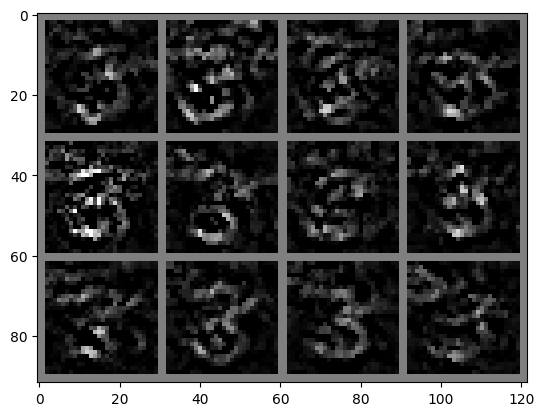

In [16]:
inversion = generate(model, target=3, num_iters=1000, examples=12, div=128)
images = torch.stack(inversion)
imshow(torchvision.utils.make_grid(images, nrow=4))

In [17]:
path = F"selective_trained.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [18]:
path = F"selective_trained.pt"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [19]:
for j in epoch_indices[0]:
    steps = torch.load(f"steps/{j:04}.pkl")
    print(f"\rLoading steps/{j:04}.pkl", end="")
    const = 1
    rng = np.random.default_rng(j)
    with torch.no_grad():
        for key, param in model.named_parameters():
            size = param.shape.numel()
            subset = rng.choice(size, int(size * P), replace=False, shuffle=False)
            param.view(-1)[subset] += const*steps[key]

Loading steps/0856.pkl

In [20]:
test(model, all_data_test_loader, dname="All data")
test(model, target_test_loader, dname="Forget  ")
test(model, nontarget_test_loader, dname="Retain  ")

All data: Mean loss: 0.0147, Accuracy: 7723/10000 (77%)
Forget  : Mean loss: 0.0082, Accuracy: 0/1010 (0%)
Retain  : Mean loss: 0.0066, Accuracy: 7723/8990 (86%)


tensor(0.859, device='cuda:0')


Inversion 1/12
Iteration: 1000	Loss: 0.6137032508850098
Inversion 2/12
Iteration: 1000	Loss: 0.6163400411605835
Inversion 3/12
Iteration: 1000	Loss: 0.6009183526039124
Inversion 4/12
Iteration: 1000	Loss: 0.6177076101303101
Inversion 5/12
Iteration: 1000	Loss: 0.6198878288269043
Inversion 6/12
Iteration: 1000	Loss: 0.6246336102485657
Inversion 7/12
Iteration: 1000	Loss: 0.6385303139686584
Inversion 8/12
Iteration: 1000	Loss: 0.6051210761070251
Inversion 9/12
Iteration: 1000	Loss: 0.6671836972236633
Inversion 10/12
Iteration: 1000	Loss: 0.636316716670994
Inversion 11/12
Iteration: 1000	Loss: 0.6192941069602966
Inversion 12/12
Iteration: 1000	Loss: 0.6458397507667542

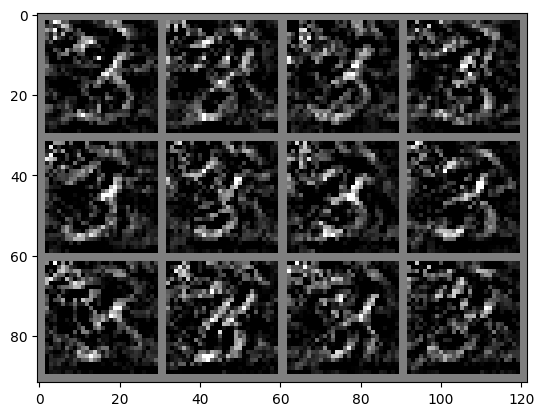

In [21]:
inversion = generate(model, target=3, num_iters=1000, examples=12, div=128)
images = torch.stack(inversion)
imshow(torchvision.utils.make_grid(images, nrow=4))

In [22]:
path = F"selective_post_trained.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [23]:
path = F"selective_post_trained.pt"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [24]:
# Train model for 10 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, nonthree_train_loader, returnable=False)
    _ = train(model, epoch, nontarget_train_loader, returnable=True)
    test(model, all_data_test_loader, dname="All data")
    test(model, target_test_loader, dname="Forget  ")
    test(model, nontarget_test_loader, dname="Retain  ")

Epoch: 5 [ 53248]	Loss: 0.005276All data: Mean loss: 0.0105, Accuracy: 8902/10000 (89%)
Forget  : Mean loss: 0.0101, Accuracy: 0/1010 (0%)
Retain  : Mean loss: 0.0005, Accuracy: 8902/8990 (99%)
Epoch: 6 [ 53248]	Loss: 0.019832All data: Mean loss: 0.0103, Accuracy: 8902/10000 (89%)
Forget  : Mean loss: 0.0099, Accuracy: 0/1010 (0%)
Retain  : Mean loss: 0.0005, Accuracy: 8902/8990 (99%)
Epoch: 7 [ 53248]	Loss: 0.007985All data: Mean loss: 0.0111, Accuracy: 8880/10000 (89%)
Forget  : Mean loss: 0.0105, Accuracy: 0/1010 (0%)
Retain  : Mean loss: 0.0007, Accuracy: 8880/8990 (99%)
Epoch: 8 [ 53248]	Loss: 0.046354All data: Mean loss: 0.0117, Accuracy: 8892/10000 (89%)
Forget  : Mean loss: 0.0112, Accuracy: 0/1010 (0%)
Retain  : Mean loss: 0.0005, Accuracy: 8892/8990 (99%)



Inversion 1/12
Iteration: 1000	Loss: 1.3674949407577515
Inversion 2/12
Iteration: 1000	Loss: 1.150813102722168
Inversion 3/12
Iteration: 1000	Loss: 1.4162561893463135
Inversion 4/12
Iteration: 1000	Loss: 1.280798077583313
Inversion 5/12
Iteration: 1000	Loss: 1.237056851387024
Inversion 6/12
Iteration: 1000	Loss: 1.226413607597351
Inversion 7/12
Iteration: 1000	Loss: 1.2454774379730225
Inversion 8/12
Iteration: 1000	Loss: 1.229622244834903
Inversion 9/12
Iteration: 1000	Loss: 1.2846461534500122
Inversion 10/12
Iteration: 1000	Loss: 1.278068184852625
Inversion 11/12
Iteration: 1000	Loss: 1.4564508199691772
Inversion 12/12
Iteration: 1000	Loss: 1.2554874420166016

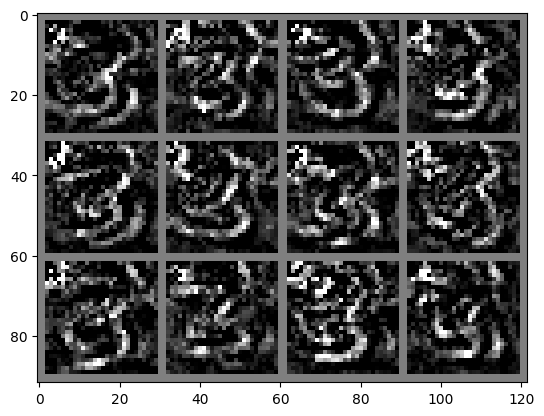

In [25]:
inversion = generate(model, target=3, num_iters=1000, examples=12, div=128)
images = torch.stack(inversion)
imshow(torchvision.utils.make_grid(images, nrow=4))